# MPh 深度实战：Tritium Cycle 动态特性分析

本教程将深入讲解如何使用 Python (MPh) 控制基于 ODE 的氚循环模型。
不仅涵盖基础的参数修改与扫描，还将深入探讨该模型的物理特性：**脉冲运行 (Pulse Operation)** 与 **饱和溢出机制 (Saturation-Overflow)**。

### 涉及模型
*   **文件**: `tritum_cycle_Model.mph`
*   **类型**: 0D 集总参数模型 (Lumped Parameter), 15 个耦合微分方程。
*   **物理背景**: 模拟聚变堆燃料循环中，氚在等离子体、第一壁、包层、储存床等 15 个节点中的流动与滞留。

### 准备工作
确保已安装 `mph`, `numpy`, `matplotlib`。



In [13]:
import mph
import numpy as np
import matplotlib.pyplot as plt
import os

# 启动 Comsol 客户端
try:
    client = mph.start()
    print(f"MPh {mph.__version__} connected to Comsol {client.version}")
except Exception as e:
    print(f"Connection failed: {e}")
    print("提示: 请检查 Comsol 是否安装及 License 状态。")


MPh 1.2.4 connected to Comsol 6.2


## 1. 模型加载与架构检查

该模型由 `tritum_cycle.java` 自动生成。我们需要加载它并确认其参数结构。



In [14]:
# 自动查找并加载模型
model_name = 'tritum_cycle_Model.mph'
search_paths = [
    model_name,
    os.path.join('..', 'experiment_00', model_name),
    r'D:\Administrator\Documents\Github	ricys_mph\experiment_00	ritum_cycle_Model.mph'
]

model = None
for p in search_paths:
    if os.path.exists(p):
        print(f"Loading model from: {p} ...")
        model = client.load(p)
        break

if not model:
    raise FileNotFoundError(f"无法找到 {model_name}，请检查路径。")

print("Model loaded successfully.")


Loading model from: tritum_cycle_Model.mph ...
Model loaded successfully.


### 检查物理参数
该模型定义了许多关键物理量，存储在 Global Parameters 中：
*   **TBR**: 氚增殖比 (Tritium Breeding Ratio)
*   **beta**: 燃烧效率
*   **T_cycle**: 运行周期 (默认 3小时)
*   **AF**: 占空比 (Availability Factor, 默认 0.5)



In [15]:
# 打印关键参数当前值
keys = ['TBR', 'beta', 'P_fusion', 'T_cycle', 'AF', 'I2_sat']
print(f"{'Parameter':<15} {'Value':<15} {'Description'}")
print("-" * 50)

for k in keys:
    try:
        val = model.parameter(k)
        # 获取描述信息通常需要 regex 解析或手动对照，这里仅展示数值
        print(f"{k:<15} {val:<15}")
    except:
        print(f"{k:<15} Not Found")


Parameter       Value           Description
--------------------------------------------------
TBR             1.1            
beta            0.06           
P_fusion        1500[MW]       
T_cycle         3[h]           
AF              0.5            
I2_sat          640[g]         


## 1.1 递归查看模型树并打印

下面提供一个递归遍历工具函数，用于打印 MPh 模型树结构，便于确认研究与求解器节点标签。


### 模型树的理念与 name/tag 的含义

在 COMSOL 中，所有对象都组织在一棵“模型树”里：参数、函数、组件、物理场、研究、求解器与结果都是树上的节点。
MPh 访问模型的方式就是沿着这棵树进行导航，因此理解模型树能直接提升脚本稳定性与可维护性。

**name 与 tag 的区别**
- **name**：展示给用户看的名称，可能会被本地化或手动重命名（如“研究 1”“瞬态”）。
- **tag**：系统内部标识符，通常是唯一且稳定的（如 `std1`、`time`、`sol1`）。在脚本中应优先用 `tag` 来定位节点。

**为什么 physics / variables / functions 在顶层也会出现**
- 顶层分组是**全局管理容器**，用于统一管理对象并与研究/求解流程对接。
- 组件分支（如 `components/comp1`）是**具体实例**，用于描述实际计算域中的物理场与变量。
- 因此你会同时看到顶层分组与组件子树；这是“全局管理 + 组件实例”并存的结构。

**模型树在 COMSOL 调用流程中的作用**
- **模型构建**：脚本创建参数、函数、物理场等节点，本质上是在模型树上新增分支。
- **求解控制**：研究与求解器节点（studies/solvers）决定了求解的时间步长与算法配置。
- **结果输出**：绘图与导出节点（results/exports）决定输出内容与格式。

因此，模型树既是 COMSOL 模型的“数据结构”，也是自动化脚本的“导航地图”。使用 MPh 时，理解模型树结构可以避免节点找不到、标签不一致等常见问题。


### 示例与配图说明

**示例：`name` 与 `tag`**

- UI 显示（name）：研究 1、瞬态
- 内部标识（tag）：`std1`、`time`

这意味着：`model / 'studies' / 'std1' / 'time'` 通常比 `model / 'studies' / '研究 1' / '瞬态'` 更稳定。

**示例：模型树的层级结构（示意图）**

```text
Model
├─ parameters (param)
├─ functions (func)
│  └─ an1 [tag=an1, name=Analytic]
├─ components (comp)
│  └─ comp1 [tag=comp1, name=Component 1]
│     ├─ physics
│     │  └─ ge [tag=ge, name=Global Equations]
│     └─ variables
│        └─ var1 [tag=var1]
├─ studies
│  └─ std1 [tag=std1, name=研究 1]
│     └─ time [tag=time, name=瞬态]
├─ solvers
│  └─ sol1 [tag=sol1]
└─ results
   └─ pg1 [tag=pg1]
```

**配图说明**：
- 从根节点 `Model` 向下分支，依次是参数、函数、组件、研究、求解器和结果。
- 每个节点都有 `name`（显示名称）与 `tag`（内部标识）。
- 脚本里推荐优先使用 `tag`，可避免本地化或重命名导致的路径失效。


In [22]:
def node_label(node):
    try:
        name = node.name()
    except Exception:
        name = "<unknown>"
    try:
        tag = node.java.tag() if hasattr(node, 'java') else ""
    except Exception:
        tag = ""
    return f"{name}{f' [tag={tag}]' if tag else ''}"

def get_children(node):
    try:
        return list(node)
    except Exception:
        return []

def print_divider(title=""):
    line = "=" * 60
    if title:
        print(f"\n{line}\n{title}\n{line}")
    else:
        print(f"\n{line}\n{line}")

def print_tree_ascii(node, prefix="", is_last=True, max_depth=10):
    """以示意图格式递归打印模型树。"""
    if max_depth < 0:
        return
    connector = "└─ " if is_last else "├─ "
    print(prefix + connector + node_label(node))
    children = get_children(node)
    for i, child in enumerate(children):
        last = i == len(children) - 1
        new_prefix = prefix + ("   " if is_last else "│  ")
        print_tree_ascii(child, new_prefix, last, max_depth - 1)

def print_tree_group(title, root, max_depth=10):
    if root is None:
        print_divider(f"[{title}] not accessible")
        return
    print_divider(f"[{title}]")
    print("Model")
    print_tree_ascii(root, prefix="", is_last=True, max_depth=max_depth)

def get_study_root(model):
    try:
        return model / 'studies'
    except Exception:
        return None

# 打印整个模型树（tritum_cycle 模型的全部元素）
print_divider("[Model]")
print("Model")
print_tree_ascii(model, prefix="", is_last=True, max_depth=10)

# 统计：所有挂载子节点的二级节点（Model 的直接子节点且有子节点）
second_level = get_children(model)
second_level_with_children = [n for n in second_level if len(get_children(n)) > 0]
print_divider("[Second-level nodes with children]")
for n in second_level_with_children:
    print(f"- {node_label(n)}")

# 分别打印所有已挂载子节点的二级节点模型树
print_divider("[Second-level subtree dumps]")
for idx, n in enumerate(second_level_with_children):
    print(f"(Subtree {idx+1}) {node_label(n)}")
    print_tree_ascii(n, prefix="", is_last=True, max_depth=10)
    print("-")



[Model]
Model
└─ tritum_cycle_Model [tag=model2]
   ├─ parameters [tag=group]
   │  ├─ Global Parameters [tag=default]
   │  ├─ 参数 2 [tag=par2]
   │  ├─ 参数 3 [tag=par3]
   │  ├─ 参数 5 [tag=par5]
   │  └─ 参数 4 [tag=par4]
   ├─ functions [tag=func]
   │  └─ 解析 1 [tag=an1]
   ├─ components [tag=modelNode]
   │  └─ 组件 1 [tag=comp1]
   ├─ geometries [tag=geom]
   ├─ views [tag=view]
   ├─ selections [tag=selection]
   ├─ coordinates [tag=coordsys]
   ├─ variables [tag=expr]
   │  └─ 变量 1 [tag=var1]
   ├─ couplings [tag=cpl]
   ├─ physics [tag=physics]
   │  └─ 全局常微分和微分代数方程 [tag=ge]
   │     └─ 全局方程 1 [tag=ge1]
   ├─ multiphysics [tag=multiphysics]
   ├─ materials [tag=material]
   ├─ meshes [tag=mesh]
   ├─ studies [tag=study]
   │  └─ 研究 1 [tag=std1]
   │     └─ 瞬态 [tag=time]
   ├─ solutions [tag=sol]
   │  └─ 解 1 [tag=sol1]
   │     ├─ 编译方程: 瞬态 [tag=st1]
   │     ├─ 因变量 1 [tag=v1]
   │     │  └─ 全局方程 1 (comp1.ODE1) [tag=comp1_ODE1]
   │     └─ 瞬态求解器 1 [tag=t1]
   │        ├─ 直接 [tag=dDef]

In [40]:
mph.tree(model)

tritum_cycle_Model
├─ parameters
│  ├─ Global Parameters
│  ├─ 参数 2
│  ├─ 参数 3
│  ├─ 参数 5
│  └─ 参数 4
├─ functions
│  └─ 解析 1
├─ components
│  └─ 组件 1
├─ geometries
├─ views
├─ selections
├─ coordinates
├─ variables
│  ├─ 变量 1
│  ├─ Derived Variables 1
│  └─ Derived Variables 2
├─ couplings
├─ physics
│  └─ 全局常微分和微分代数方程
│     └─ 全局方程 1
├─ multiphysics
├─ materials
├─ meshes
├─ studies
│  └─ 研究 1
│     └─ 瞬态
├─ solutions
│  └─ 解 1
│     ├─ 编译方程: 瞬态
│     ├─ 因变量 1
│     │  └─ 全局方程 1 (comp1.ODE1)
│     └─ 瞬态求解器 1
│        ├─ 直接
│        ├─ 高级
│        ├─ 全耦合
│        └─ 全耦合 1
├─ batches
├─ datasets
│  └─ 研究 1//解 1
├─ evaluations
├─ tables
├─ plots
│  ├─ Full Tritium Inventory Comparison
│  │  └─ 全局 1
│  └─ SDS Tritium Inventory Trend
│     └─ 全局 2
└─ exports
   ├─ 图像 1
   └─ 图像 2


## 2. 捕捉瞬态特性：脉冲运行分析

该模型使用 `f_pulse(t)` 函数模拟聚变堆的 "开-关" 循环。
为了看清这个过程，我们需要进行一次**高时间分辨率**的短时求解。
默认求解器设置了 360 天，步长 1 天，这会完全漏掉周期为 3 小时的脉冲细节。

**任务**：仅模拟 12 小时 (4 个周期)，输出细密的点（1 分钟步长），并使用稳健的研究节点定位与求解方式。


In [25]:
# 1. 创建一个新的临时研究用于短时分析
# 我们不修改原有的 std1，而是利用 Python 动态控制求解时间
# 但 MPh 主要是封装，直接调用 solve 会运行模型里预设的设置。
# 技巧：我们可以临时修改原有 Study 的时间设置，运行完再改回来（或者只改 Study）

print("Configuring short-term high-resolution simulation...")

def find_time_node(root):
    """Recursively search for a node named 'time' under the given root."""
    for node in root:
        try:
            if hasattr(node, 'java') and node.java.tag() == 'time':
                return node
        except Exception:
            pass
        try:
            result = find_time_node(node)
            if result:
                return result
        except Exception:
            pass
    return None

def get_study_tag(study_root):
    if study_root is None:
        return None
    for study in study_root:
        try:
            if hasattr(study, 'java'):
                return str(study.java.tag())
            return str(study.name())
        except Exception:
            pass
    return None

def solve_model(model, study_root):
    study_tag = get_study_tag(study_root)
    if study_tag:
        try:
            model.solve(study_tag)
            return
        except Exception:
            pass
    model.solve()

study_root = get_study_root(model)
if study_root is None:
    raise RuntimeError("Unable to access 'studies' node in model tree.")

study_time_node = None
# Prefer std1/time by tag, then fall back to recursive search
for study in study_root:
    try:
        if hasattr(study, 'java') and study.java.tag() == 'std1':
            for feat in study:
                try:
                    if hasattr(feat, 'java') and feat.java.tag() == 'time':
                        study_time_node = feat
                        break
                except Exception:
                    pass
    except Exception:
        pass
    if study_time_node is not None:
        break

if study_time_node is None:
    study_time_node = find_time_node(study_root)
if study_time_node is None:
    raise KeyError("No 'time' node found in the model")

# 设置为 12小时 (43200秒)，每 1 分钟 (60秒) 输出一个点
study_time_node.property('tlist', 'range(0, 60, 43200)')

# 求解
solve_model(model, study_root)
print("Short-term simulation finished.")


Study "std1" does not exist.


Configuring short-term high-resolution simulation...
Short-term simulation finished.


### 可视化脉冲



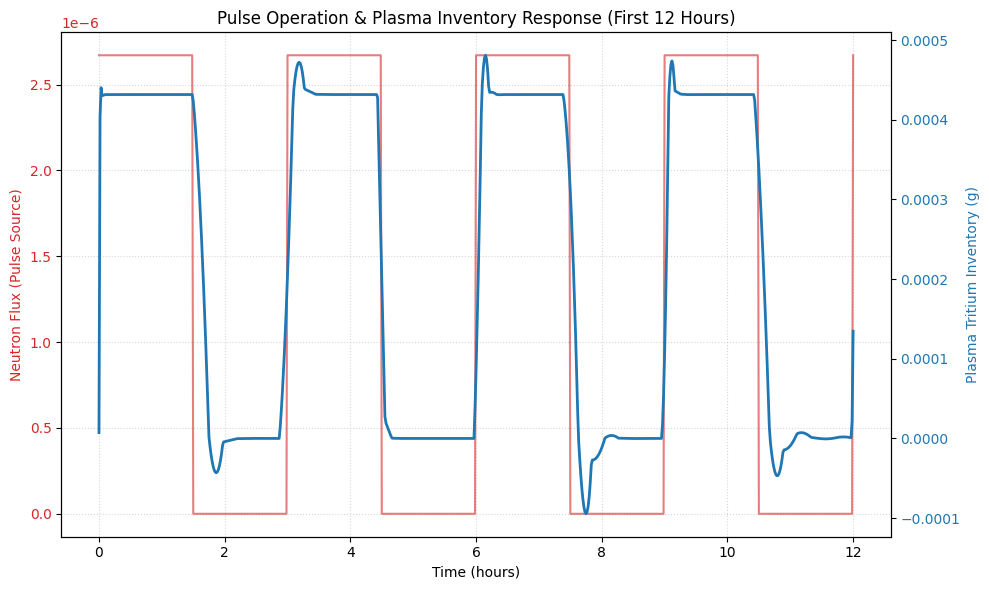

In [26]:
# 提取 'N_flux' (中子通量/燃烧率) 和 'I15' (等离子体氚量)
time_h = model.evaluate('t', unit='h')
n_flux = model.evaluate('N_flux')
i_plasma = model.evaluate('I15', unit='g')

# 如需恢复原始设置，可手动改回 tlist

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Neutron Flux (Pulse Source)', color=color)
ax1.plot(time_h, n_flux, color=color, alpha=0.6, label='N_flux')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Pulse Operation & Plasma Inventory Response (First 12 Hours)')
ax1.grid(True, linestyle=':', alpha=0.5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Plasma Tritium Inventory (g)', color=color)  # we already handled the x-label with ax1
ax2.plot(time_h, i_plasma, color=color, linewidth=2, label='I15 (Plasma)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


**分析**：
从图中可以清晰看到，随着 N_flux (红色) 的周期性开启和关闭，等离子体中的氚库存 (蓝色) 呈现出**充-放**的锯齿波形。
这是 0D 动态模型相对于稳态模型的核心优势，能捕捉疲劳载荷。



## 3. 探究非线性机制：饱和溢出检测

模型中很多部件（如泵 I2）具有饱和阈值 `I_sat`。
当库存 $I(t)$ 超过 $I_{sat}$ 时，流出项才会被激活。我们将验证这一行为。



In [ ]:
# 提取 I2 (Pumping System) 的数据
i_pump = model.evaluate('I2', unit='g')
# 获取 I2 的饱和阈值参数
i2_sat_val = model.parameter('I2_sat', evaluate=True) # 返回数值，单位 g

# 绘图验证
plt.figure(figsize=(10, 5))
plt.plot(time_h, i_pump, label='I2 (Pump Inventory)', linewidth=2)
plt.axhline(y=i2_sat_val, color='r', linestyle='--', label=f'Saturation Limit ({i2_sat_val} g)')

plt.xlabel('Time (hours)')
plt.ylabel('Inventory (g)')
plt.title('Saturation-Overflow Mechanism Verification (Node I2)')
plt.legend()
plt.grid(True)
plt.show()


## 4. 关键参数扫描：寻找自持平衡点

系统能否维持氚自持（Self-sufficiency），取决于 TBR 是否足够高以抵消衰变和处理损失。
我们将恢复长时运行设置 (360天)，并扫描 TBR，观察 SDS 储存 (I12) 在一年后的净积累量。

*   **TBR < 1.0**: 肯定亏损。
*   **TBR > 1.0**: 理论上增殖，但需要克服系统损失。



In [ ]:
print("Restoring long-term simulation settings (360 days)...")
# 恢复为长时计算：360天，步长1天
long_term_range = 'range(0, 86400, 31104000)' # 360 days

study_root = get_study_root(model)
if study_root is None:
    raise RuntimeError("Unable to access 'studies' node in model tree.")

study_time_node = find_time_node(study_root)
if study_time_node is None:
    raise KeyError("No 'time' node found in the model")
study_time_node.property('tlist', long_term_range)

# 定义 TBR 扫描区间
tbr_scan = [1.0, 1.05, 1.1, 1.2, 1.3]
final_sds_storage = []

print(f"Starting sweep for TBR: {tbr_scan}")

for val in tbr_scan:
    model.parameter('TBR', val)
    solve_model(model, study_root)
    
    # 获取最后一天的 SDS 库存 (I12)
    data = model.evaluate('I12', unit='kg')
    final_sds_storage.append(data[-1])
    print(f"  TBR = {val:.2f} -> Year-End SDS: {data[-1]:.3f} kg")

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(tbr_scan, final_sds_storage, 's-', markersize=8, color='green')

# 标记初始库存线 (假设初始 SDS 库存为 I12_ini)
i12_ini = model.parameter('I12_ini', evaluate=True) / 1000.0 # 换算为 kg
plt.axhline(y=i12_ini, color='gray', linestyle='--', label=f'Initial Inventory ({i12_ini} kg)')

plt.xlabel('Tritium Breeding Ratio (TBR)')
plt.ylabel('SDS Inventory after 1 Year [kg]')
plt.title('Fuel Cycle Self-Sufficiency Analysis')
plt.legend()
plt.grid(True)
plt.show()

## 总结

通过本教程，你实际上完成了一次完整的计算机辅助工程 (CAE) 分析流程：
1.  **物理理解**: 识别模型中的关键机制 (脉冲、饱和)。
2.  **验证**: 通过短时高分辨模拟验证了脉冲逻辑。
3.  **机理分析**: 验证了饱和溢出控制逻辑。
4.  **设计优化**: 通过参数扫描找到了维持系统氚平衡所需的最小 TBR。

这正是 MPh 结合 Python 生态的强大之处 —— 它不仅仅是运行仿真，更是**理解**和**探索**仿真。

